## How well do jobs and skills pay for Data Jobs?

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
from plot_utils import save_plot_for_github

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else(x))

4.1. Checking for missing values in salary column

In [2]:
df_Germany = df[df['job_country'] == 'Germany']
print(f"Total job offers in Germany: {len(df_Germany)}")
print(f"Missing salary data: {df_Germany['salary_year_avg'].isnull().sum()}")
print(f"Job offers with provided salary data: {df_Germany['salary_year_avg'].notnull().sum()}")
print(f"Jobs with salary data: {len(df_Germany[df_Germany['salary_year_avg'].notnull()])} ({len(df_Germany[df_Germany['salary_year_avg'].notnull()]) / len(df_Germany) * 100:.2f}% of total)")
print(f"Missing salary data: {df_Germany['salary_year_avg'].isnull().sum()} ({df_Germany['salary_year_avg'].isnull().sum() / len(df_Germany) * 100:.2f}% of total)")

Total job offers in Germany: 27694
Missing salary data: 27437
Job offers with provided salary data: 257
Jobs with salary data: 257 (0.93% of total)
Missing salary data: 27437 (99.07% of total)


In [3]:
# Including top 7 job titles with salary data
df_Germany_with_salary = df_Germany[df_Germany['salary_year_avg'].notnull()].copy()

job_titles = df_Germany_with_salary['job_title_short'].value_counts().index[:7].tolist()
job_titles

['Data Analyst',
 'Data Scientist',
 'Data Engineer',
 'Machine Learning Engineer',
 'Senior Data Engineer',
 'Senior Data Scientist',
 'Senior Data Analyst']

4.2. Creating new dataframe including top 7 data jobs for more salary data

In [4]:
df_Germany_top7 = df_Germany_with_salary[df_Germany_with_salary['job_title_short'].isin(job_titles)].copy()

4.3. Plotting salary distribution based on job title

✅ Full PNG saved: docs/images/4.1. Salary Distribution by Job Title in Germany.png.png (2400px wide with scale=2)
✅ Preview saved: docs/images/4.1. Salary Distribution by Job Title in Germany.png_preview.png (800px wide)
✅ HTML saved: docs/4.1. Salary Distribution by Job Title in Germany.png.html (24.4 KB)


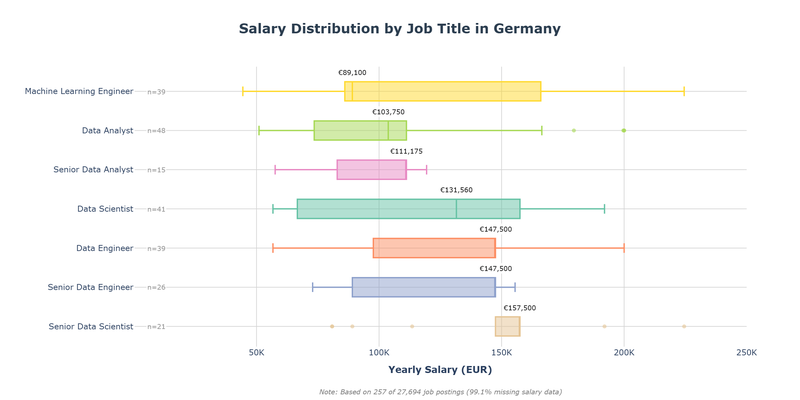

📊 Preview displayed in notebook (800px wide)


{'png_full': 'docs/images/4.1. Salary Distribution by Job Title in Germany.png.png',
 'preview': 'docs/images/4.1. Salary Distribution by Job Title in Germany.png_preview.png',
 'html': 'docs/4.1. Salary Distribution by Job Title in Germany.png.html',
 'preview_width': 800}

In [5]:
# Defing color palette
COLOR_PALETTE = px.colors.qualitative.Set2  

# Getting median values and assigning colors
median_df = (
    df_Germany_top7
    .groupby('job_title_short')['salary_year_avg']
    .median()
    .reset_index()
)

roles = df_Germany_top7['job_title_short'].unique()
role_colors = {role: COLOR_PALETTE[i % len(COLOR_PALETTE)] for i, role in enumerate(roles)}

# Creating boxplot with different colors
fig = px.box(
    df_Germany_top7,
    x='salary_year_avg',
    y='job_title_short',
    orientation='h',
    title='<b>Salary Distribution by Job Title in Germany</b>',
    labels={
        'salary_year_avg': 'Yearly Salary (EUR)',
        'job_title_short': 'Job Title'
    },
    color='job_title_short',
    color_discrete_map=role_colors,  
    category_orders={'job_title_short': median_df.sort_values('salary_year_avg')['job_title_short'].tolist()}
)

fig.update_traces(
    marker_opacity=0.6,
    line_width=2,
    hoverinfo='none',  
    hovertemplate=None
)

# Adding visible median lines and hover-able points
for _, row in median_df.iterrows():
    role = row['job_title_short']
    median_value = row['salary_year_avg']
    role_color = role_colors[role]
    
    fig.add_shape(
        type="line",
        x0=median_value,
        x1=median_value,
        y0=role,
        y1=role,
        yref="y",
        line=dict(
            color=role_color,
            width=3,
            dash="solid"  
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=[median_value],
            y=[role],
            mode='markers',
            marker=dict(
                size=15,  
                opacity=0,  
                color=role_color
            ),
            hovertemplate=(
                f'<b style="color:{role_color}">{role}</b><br>'
                f'<b>Median Salary:</b> €{median_value:,.0f}<br>'
                f'<extra></extra>'
            ),
            showlegend=False,
            name=f'{role} Median'
        )
    )
    
    fig.add_annotation(
        x=median_value,
        y=role,
        text=f'€{median_value:,.0f}',
        showarrow=False,
        yshift=20,  
        font=dict(size=10, color='black'),
        bgcolor='white',
        opacity=0.9,
        yanchor='bottom'
    )

fig.update_layout(
    height=550,  
    width=800,
    showlegend=False,
    plot_bgcolor='white',
    xaxis=dict(
        range=[0, 250000],
        ticksuffix=' €',
        gridcolor='lightgray',
        gridwidth=1,
        title='<b>Yearly Salary (EUR)</b>'
    ),
    yaxis=dict(
        title='',
        gridcolor='lightgray',
        gridwidth=1
    ),
    title=dict(
        x=0.5,
        font=dict(size=20, color='#2c3e50')
    ),
    hovermode='closest'
)
fig.update_xaxes(
    tickvals=[0, 50000, 100000, 150000, 200000, 250000],
    ticktext=['', '50K', '100K', '150K', '200K', '250K']
)

# Adding data count annotations
for i, role in enumerate(roles):
    role_data = df_Germany_top7[df_Germany_top7['job_title_short'] == role]
    count = len(role_data)
    
    fig.add_annotation(
        x=0.02,
        y=role,
        xref="paper",
        yref="y",
        text=f"n={count}",
        showarrow=False,
        font=dict(size=10, color="gray"),
        bgcolor="white",
        opacity=0.8,
        xanchor='left'
    )

# Adding disclaimer
total_jobs = len(df_Germany)
jobs_with_salary = len(df_Germany_with_salary)
missing_pct = ((total_jobs - jobs_with_salary) / total_jobs) * 100

fig.add_annotation(
    x=0.5,
    y=-0.18,
    xref="paper",
    yref="paper",
    text=f"<i>Note: Based on {jobs_with_salary:,} of {total_jobs:,} job postings ({missing_pct:.1f}% missing salary data)</i>",
    showarrow=False,
    font=dict(size=10, color="gray"),
    align="center"
)

save_plot_for_github(fig, '4.1. Salary Distribution by Job Title in Germany.png')

4.4. Comparing median salaries with coresponding tech skills

In [6]:
# Exploding job skills for further analysis
df_Germany_top7_exploded = df_Germany_top7.explode('job_skills')

In [7]:
df_Germany_top7_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
1363,56700.0,spark
7772,199675.0,spark
10610,147500.0,go
10610,147500.0,redshift
10610,147500.0,snowflake


In [8]:
# Analyzing top skills by median salary
df_Germany_top_pay = df_Germany_top7_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='median', ascending=False)

df_Germany_top_pay = df_Germany_top_pay.head(10)
df_Germany_top_pay.head(10)

,count,median
job_skills,,
rust,1,224500.0
opencv,1,224500.0
fastapi,2,166680.5
keras,3,157500.0
hadoop,8,157500.0
kubernetes,17,157500.0
jenkins,8,157500.0
nltk,1,157500.0
nosql,3,157500.0


In [9]:
# Analyzing top skills by frequency
df_Germany_top_skills = df_Germany_top7_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_Germany_top_skills = df_Germany_top_skills.head(10).sort_values(by='median', ascending=False)
df_Germany_top_skills.head(10)

,count,median
job_skills,,
aws,48,147500.0
spark,64,147500.0
looker,19,147500.0
airflow,24,147500.0
snowflake,20,147500.0
python,125,146000.0
azure,29,140904.5
sql,98,126062.0
tableau,25,111175.0


4.5. Plotting a comparison between top most paying skills versus most frequently required

✅ Full PNG saved: docs/images/4.2. Skill Analysis for Data Jobs in Germany.png.png (2400px wide with scale=2)
✅ Preview saved: docs/images/4.2. Skill Analysis for Data Jobs in Germany.png_preview.png (800px wide)
✅ HTML saved: docs/4.2. Skill Analysis for Data Jobs in Germany.png.html (13.4 KB)


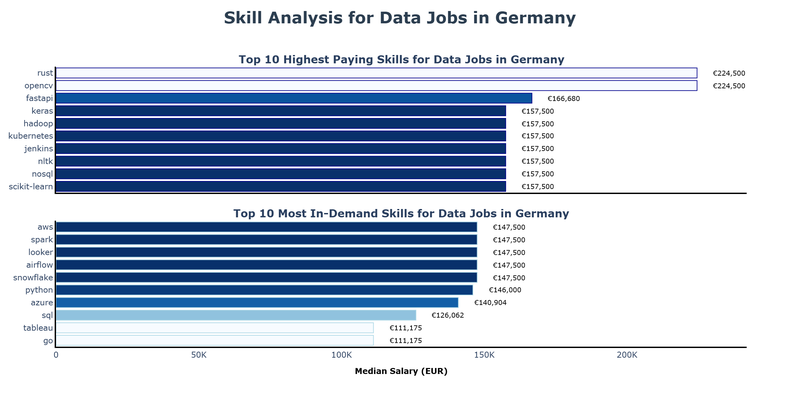

📊 Preview displayed in notebook (800px wide)


{'png_full': 'docs/images/4.2. Skill Analysis for Data Jobs in Germany.png.png',
 'preview': 'docs/images/4.2. Skill Analysis for Data Jobs in Germany.png_preview.png',
 'html': 'docs/4.2. Skill Analysis for Data Jobs in Germany.png.html',
 'preview_width': 800}

In [10]:
# Creating subplots
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=[
        '<b>Top 10 Highest Paying Skills for Data Jobs in Germany</b>',
        '<b>Top 10 Most In-Demand Skills for Data Jobs in Germany</b>'
    ],
    vertical_spacing=0.1,
    shared_xaxes=True
)

# 1. Top paying skills (top plot)
fig.add_trace(
    go.Bar(
        y=df_Germany_top_pay.index,
        x=df_Germany_top_pay['median'],
        orientation='h',
        name='Highest Paying',
        marker=dict(
            color=df_Germany_top_pay['median'],
            colorscale='Blues_r',
            showscale=False,
            line=dict(color='darkblue', width=1)
        ),
        hovertemplate='<b>%{y}</b><br>€%{x:,.0f}<br><extra></extra>'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Bar(
        y=df_Germany_top_skills.index,
        x=df_Germany_top_skills['median'],
        orientation='h',
        name='Most In-Demand',
        marker=dict(
            color=df_Germany_top_skills['median'],
            colorscale='Blues',
            showscale=False,
            line=dict(color='lightblue', width=1)
        ),
        hovertemplate='<b>%{y}</b><br>€%{x:,.0f}<br><extra></extra>'
    ),
    row=2, col=1
)
fig.update_layout(
    height=700,
    width=900,
    showlegend=False,
    plot_bgcolor='white',
    title=dict(
        text='<b>Skill Analysis for Data Jobs in Germany</b>',
        font=dict(size=24, color='#2c3e50'),
        x=0.5,
        y=0.97
    )
)
fig.update_xaxes(
    title_text='<b>Median Salary (EUR)</b>',
    tickformat=',.0f',
    ticksuffix=' €',
    tickvals=[0, 50000, 100000, 150000, 200000, 250000],
    ticktext=['0', '50K', '100K', '150K', '200K', '250K'],
    title_font=dict(size=12, color='black'),
    row=2, col=1,
    showline=True,
    linewidth=2,
    linecolor='black',
)
fig.update_xaxes(
    title_text='',
    showline=True,
    linewidth=2,
    linecolor='black',
    row=1, col=1
)

fig.update_yaxes(
    autorange='reversed',
    row=1, col=1,
    showline=True,
    linewidth=2,
    linecolor='black'
)

fig.update_yaxes(
    autorange='reversed',
    row=2, col=1,
    showline=True,
    linewidth=2,
    linecolor='black'
)

# Adding value labels on bars
for i in range(2):
    df = df_Germany_top_pay if i == 0 else df_Germany_top_skills
    
    for idx, (skill, row) in enumerate(df.iterrows()):
        fig.add_annotation(
            x=row['median'] + 5000,
            y=skill,
            text=f'€{row["median"]:,.0f}',
            showarrow=False,
            font=dict(size=10, color='black'),
            xanchor='left',
            row=i+1, col=1
        )

save_plot_for_github(fig, '4.2. Skill Analysis for Data Jobs in Germany.png')